In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import random
import shap
random.seed(10)

#### prepare inputs

In [2]:
Oper_group = pd.read_csv("ML_operation_group.csv")      

#Oper_group.info()
Not_used_columns1 = ['Substrate1','Sub_weight1','Substrate2','Sub_weight2','Sample name']

# this table containing group info will be used for stratified sampling
Oper_group_temp1 = Oper_group.drop(columns = Not_used_columns1,axis=1) 

# this table containing only the useful operational information
Not_used_columns2 = ['Microbial sample', 'Group', 'Methanogenesis efficiency']
Oper_group_temp2 = Oper_group_temp1.drop(columns = Not_used_columns2,axis=1) 

# Methane yield is to be predicted
Target_name = "Methanogenesis efficiency"
Target = Oper_group_temp1[Target_name]
# Target

In [3]:
# this is used to transform numerical and catagorical data
def inputs_encoding(df):   

    from sklearn.compose import make_column_selector as selector    #seperate numerical data and categorical data

    numerical_columns_selector = selector(dtype_exclude=object)
    categorical_columns_selector = selector(dtype_include=object)

    numerical_columns = numerical_columns_selector(df)
    categorical_columns = categorical_columns_selector(df)

    df_categorical = df[categorical_columns]
    df_numerical = df[numerical_columns]

    from sklearn.preprocessing import OneHotEncoder, StandardScaler   #OneHotEncoder process n categorical features in to n columns

    categorical_processor = OneHotEncoder(handle_unknown="ignore")  
    #numerical_processor = StandardScaler()

    df_categorical_encoded = categorical_processor.fit_transform(df_categorical)
    df_categorical_encoded_array = df_categorical_encoded.toarray()
    categorical_columns_encoded = categorical_processor.get_feature_names_out(df_categorical.columns)
    df_categorical_trans = pd.DataFrame(df_categorical_encoded_array, columns=categorical_columns_encoded, index = df.index)    

    #df_numerical_encoded = numerical_processor.fit_transform(df_numerical)
    #numerical_columns_encoded = numerical_processor.get_feature_names_out(df_numerical.columns)
    #df_numerical_trans = pd.DataFrame(df_numerical_encoded, columns=numerical_columns_encoded, index = df.index)

    df_trans = pd.concat([df_categorical_trans, df_numerical], axis=1)

    return df_trans

In [4]:
Oper_trans = inputs_encoding(Oper_group_temp2)
#df_trans.columns
Oper_trans.head()

,Reactor type_Anaerobic sequencing batch reactors,Reactor type_UASB,Feeding strategy_Continuous,Feeding strategy_Continuous with eff recirculation,Feeding strategy_Semi-continuous,Substrate_50% Glucose + 50% BSA,Substrate_60% Glucose + 40% BSA,Substrate_75% Glucose + 25% BSA,Substrate_Acetate and glucose,Substrate_BSA,...,VFA.eff,FA,SRT,GAC amount,Specific surface area,V GAC/V total,Hydrolysis efficiency,Acidogenesis efficiency,SMA-acetate,SMA-hydrogen
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.1268,0.220
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.1540,0.133
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.2010,0.142
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.4960,3.540
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.0522,0.394


#### define the model and search cv

In [5]:
# this is the model composing for LGBMRegressor and hyperparameter range

from lightgbm import LGBMRegressor

Regressor = LGBMRegressor(random_state=42, use_missing = True)

from sklearn import set_config
# To get a diagram visualization of the pipeline
set_config(display="diagram")
Regressor

# To get the hyperparameters to be tuned
# for parameter in Regressor.get_params(): 
#     print(parameter)
    
# To make the distribution space of hyperparameters
from scipy.stats import loguniform

class loguniform_int:
    """Integer valued version of the log-uniform distribution"""
    def __init__(self, a, b):
        self._distribution = loguniform(a, b)

    def rvs(self, *args, **kwargs):
        """Random variable sample"""
        return self._distribution.rvs(*args, **kwargs).astype(int)

param_distributions = {
    #'regressor__reg_alpha': loguniform(1e-6, 1e3),
    #'regressor__reg_lambda': loguniform(1e-6, 1e3),
    'num_leaves':stats.randint(1, 600),
    'learning_rate': [0.0001,0.001, 0.1, 0.3, 0.5],
    #'regressor__max_leaves': loguniform_int(2, 256),
    'max_depth': loguniform_int(1, 501),
    #'min_child_weight': stats.uniform(1e-6, 1e-2),
    'min_child_samples': loguniform_int(2, 100),
    #'regressor__max_bin': loguniform_int(2, 255),
    #'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500, 800],
    #'regressor__subsample':[0.2, 0.8, 1.0],
    #'gamma':loguniform(1e-6, 5),
}

In [6]:
### the inner_cv is used to cross validate the each dataframe in Total_train
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GroupShuffleSplit,ShuffleSplit

inner_cv = ShuffleSplit(n_splits=5, train_size=.8, random_state=42)

search_cv = RandomizedSearchCV(
    Regressor, param_distributions=param_distributions,
    scoring="neg_mean_absolute_error", n_iter=20, random_state=0, n_jobs=2, cv=inner_cv     #here the cv is the inner cross validation
)

search_cv

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=0.8),
                   estimator=LGBMRegressor(random_state=42, use_missing=True),
                   n_iter=20, n_jobs=2,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.1,
                                                          0.3, 0.5],
                                        'max_depth': <__main__.loguniform_int object at 0x14e1b04f0>,
                                        'min_child_samples': <__main__.loguniform_int object at 0x14e1ac790>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14e13a4f0>},
                   random_state=0, scoring='neg_mean_absolute_error')

In [7]:
# this is the Stratified spliter and cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit

S_group = Oper_group_temp1['Group']
S_group

SKf_gen = StratifiedKFold(n_splits=5, shuffle=True,random_state=0)
SSS_gen = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

S_split = SKf_gen.split(Oper_trans, S_group)

# outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# outer_cv_1 = KFold(n_splits=5, shuffle=True, random_state=10)
scoring = ['neg_mean_absolute_error', 'r2']
cv_results = cross_validate(
    search_cv, Oper_trans, Target, cv=S_split, n_jobs=2, return_estimator=True, scoring=scoring)    #here the cv is the outer cross validation

In [8]:
# this is used to verify the searchcv.best_estimator_ retrieve the correct tuned parameters
cv_results_test = pd.DataFrame(cv_results)
cv_test_error = -cv_results_test["test_neg_mean_absolute_error"]
cv_test_error_df = pd.DataFrame(cv_test_error)

for cv_fold, estimator_in_fold in enumerate(cv_results_test["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'learning_rate': 0.1, 'max_depth': 17, 'min_child_samples': 18, 'num_leaves': 129}
Best hyperparameters for fold #2:
{'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 5, 'num_leaves': 460}
Best hyperparameters for fold #3:
{'learning_rate': 0.5, 'max_depth': 57, 'min_child_samples': 5, 'num_leaves': 144}
Best hyperparameters for fold #4:
{'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 5, 'num_leaves': 460}
Best hyperparameters for fold #5:
{'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 5, 'num_leaves': 460}


In [9]:
Train = [pd.DataFrame() for df in range(5)]
Test = [pd.DataFrame() for df in range(5)]
for idx, split_index in enumerate(SKf_gen.split(Oper_trans, S_group)):
        # print("Split_count:", idx, "TRAIN:", split_index[0], "TEST:", split_index[1])
        Train[idx] = Oper_trans.loc[split_index[0]]
        Test[idx]= Oper_trans.loc[split_index[1]]

i = cv_results_test['test_r2'].idxmax()
        
Target_tune_para = Target.loc[Train[i].index]

search_cv.fit(X = Train[i], y = Target_tune_para)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=0.8),
                   estimator=LGBMRegressor(random_state=42, use_missing=True),
                   n_iter=20, n_jobs=2,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.1,
                                                          0.3, 0.5],
                                        'max_depth': <__main__.loguniform_int object at 0x14e1b04f0>,
                                        'min_child_samples': <__main__.loguniform_int object at 0x14e1ac790>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14e13a4f0>},
                   random_state=0, scoring='neg_mean_absolute_error')

In [10]:
search_cv.best_estimator_

LGBMRegressor(max_depth=13, min_child_samples=5, num_leaves=460,
              random_state=42, use_missing=True)

In [11]:
from sklearn.model_selection import cross_val_predict

S_split = SKf_gen.split(Oper_group_temp2, S_group)
Target_pred = cross_val_predict(search_cv.best_estimator_, Oper_trans, Target, cv=S_split)
# Target_pred

from sklearn.metrics import mean_absolute_error
#target_predicted = Tuned_model.predict(data_test)
print(f"Mean absolute error: "
      f"{mean_absolute_error(Target, Target_pred):.3f}")
MAE=mean_absolute_error(Target, Target_pred)

from sklearn.metrics import r2_score
print(f"r^2_score: "
      f"{r2_score(Target, Target_pred):.3f}")
R2_score=r2_score(Target, Target_pred)

from sklearn.metrics import mean_squared_error
print(f"Root mean squared error on the training set: "
      f"{mean_squared_error(Target, Target_pred, squared=False):.3f}")
RMSE=mean_squared_error(Target, Target_pred, squared=False)

Mean absolute error: 4.605
r^2_score: 0.919
Root mean squared error on the training set: 7.263


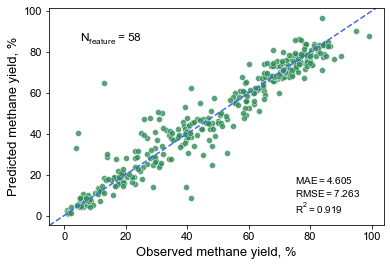

In [109]:
Target_ob_pre = pd.DataFrame({'Observed':Target, 'Predicted':Target_pred})

import matplotlib as mpl
mpl.rcParams['mathtext.default'] = 'regular'

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

ax = sns.scatterplot(data=Target_ob_pre,
                x="Observed", y="Predicted",
                color="seagreen", alpha=0.8)

tex = f'$MAE = {MAE:.3f}$\n$RMSE = {RMSE:.3f}$\n$R^2 = {R2_score:.3f}$'.format(MAE,R2_score,RMSE)

ax.text(75, 20, tex, fontsize=10,
        verticalalignment='top')
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.axline((0, 0), slope=1, linestyle = '--', color = 'royalblue', alpha=1)
ax.set_xlabel("Observed methane yield, %",fontsize=13)
ax.set_ylabel("Predicted methane yield, %",fontsize=13)
ax.text(5,85,'$N _{feature}=58$',fontsize=12,font='Arial')
#ax.axis('square')
plt.savefig('Predict_observed_oper_all.pdf')

In [12]:
# fit model for sharpley
import shap
Fit_reg = search_cv.best_estimator_.fit(Oper_trans, Target)
explainer = shap.Explainer(Fit_reg)
shap_values_all = explainer(Oper_trans)

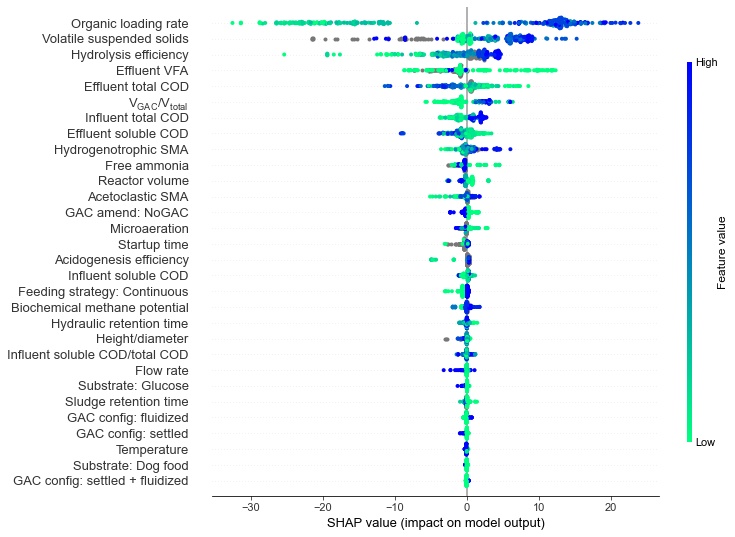

In [134]:
shap.summary_plot(shap_values_all, Oper_trans, max_display=30, plot_size=[10,9],show=False, cmap="winter_r",color_bar=True)
plt.gcf().axes[-1].set_aspect(70)
plt.gcf().axes[-1].set_box_aspect(90)
# plt.yticks(style="italic") 
plt.yticks(ticks=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
                  15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
          labels=['GAC config: settled + fluidized','Substrate: Dog food', 'Temperature','GAC config: settled',
                  'GAC config: fluidized','Sludge retention time',
                  'Substrate: Glucose','Flow rate','Influent soluble COD/total COD','Height/diameter',
                  'Hydraulic retention time','Biochemical methane potential','Feeding strategy: Continuous',
                  'Influent soluble COD','Acidogenesis efficiency','Startup time','Microaeration',
                  'GAC amend: NoGAC','Acetoclastic SMA','Reactor volume','Free ammonia','Hydrogenotrophic SMA',
                  'Effluent soluble COD','Influent total COD','$V_{GAC}/V_{total}$','Effluent total COD',
                  'Effluent VFA','Hydrolysis efficiency','Volatile suspended solids','Organic loading rate'])
plt.savefig('sharpley_beeswarm_oper_all.pdf',bbox_inches='tight')

### here started the feature reduction based on sharpley importance

In [13]:
#this is used to remove the least important features (the last one of the features sorted by sharpley importance)

value_list =  np.abs(shap_values_all.values).mean(0)
#value_list
features = Oper_trans.columns
#features
shap_feature_importance = pd.DataFrame(list(zip(features, value_list)),
                                 columns=['feature_name','shap_importance_vals'])
shap_feature_importance.sort_values(by=['shap_importance_vals'],
                              ascending=False, inplace=True)
#shap_feature_importance.info()
sel_features = list(shap_feature_importance.feature_name[:-1])
# sel_features

In [298]:
sel_features

['OLR',
 'VSS',
 'Hydrolysis efficiency',
 'VFA.eff',
 'tCOD.eff',
 'V GAC/V total',
 'tCOD.inf',
 'sCOD.eff',
 'SMA-hydrogen',
 'FA',
 'Reactor volume',
 'SMA-acetate',
 'GAC amend_NoGAC',
 'Microaeration',
 'Startup time',
 'Acidogenesis efficiency',
 'sCOD.inf',
 'Feeding strategy_Continuous',
 'BMP',
 'HRT',
 'Height/diameter',
 'sCOD/tCOD.inf',
 'Q',
 'Substrate_Glucose',
 'SRT',
 'GAC config_fluidized',
 'GAC config_settled',
 'T',
 'Substrate_Dog food',
 'GAC config_settled + fluidized',
 'Specific surface area',
 'Substrate_Half dog food+ half THP dog food',
 'Feeding strategy_Continuous with eff recirculation',
 'GAC amend_WithGAC',
 'Substrate_75% Glucose + 25% BSA',
 'Feeding strategy_Semi-continuous',
 'Reactor type_UASB',
 'Substrate_50% Glucose + 50% BSA',
 'VFA.inf',
 'Reactor type_Anaerobic sequencing batch reactors',
 'Substrate_Acetate and glucose',
 'Substrate_THP dog food',
 'Pretreat_No',
 'Substrate_60% Glucose + 40% BSA',
 'Substrate_BSA',
 'GAC amount',
 'Co-dig

In [14]:
Num_features = len(Oper_trans.columns)
R2_test_mean = cv_results_test["test_r2"].mean()
R2_test_std = cv_results_test["test_r2"].std()
MAE_test_mean = (-cv_results_test["test_neg_mean_absolute_error"]).mean()
MAE_test_std = (-cv_results_test["test_neg_mean_absolute_error"]).std()
row = [Num_features, R2_test_mean, R2_test_std, MAE_test_mean, MAE_test_std]

columns = ['Num_features', 'R2_test_mean', 'R2_test_std', 'MAE_test_mean', 'MAE_test_std']
Prediction_stats = pd.DataFrame(columns=columns)
Prediction_stats.loc[Num_features] = row

Feature_list=[]

In [15]:
Prediction_stats

,Num_features,R2_test_mean,R2_test_std,MAE_test_mean,MAE_test_std
58,58.0,0.91831,0.045466,4.656609,1.087013


In [22]:
uncalled = True

for j in range(len(Oper_trans.columns)-2):
    S_split = SKf_gen.split(Oper_trans[sel_features], S_group)
    scoring = ['neg_mean_absolute_error', 'r2']
    cv_results = cross_validate(
    search_cv, Oper_trans[sel_features], Target, cv=S_split, n_jobs=2, return_estimator=True, scoring=scoring)  #here the cv is the outer cross validation

    cv_results_redu = pd.DataFrame(cv_results)
    cv_results_redu

    Num_features = len(Oper_trans[sel_features].columns)
    R2_test_mean = cv_results_redu["test_r2"].mean()
    R2_test_std = cv_results_redu["test_r2"].std()
    MAE_test_mean = (-cv_results_redu["test_neg_mean_absolute_error"]).mean()
    MAE_test_std = (-cv_results_redu["test_neg_mean_absolute_error"]).std()
    row = [Num_features, R2_test_mean, R2_test_std, MAE_test_mean, MAE_test_std]

    Prediction_stats.loc[Num_features] = row
    # Prediction_stats

    i = cv_results_redu['test_r2'].idxmax()

    Train = [pd.DataFrame() for df in range(5)]
    Test = [pd.DataFrame() for df in range(5)]
    for idx, split_index in enumerate(SKf_gen.split(Oper_trans[sel_features], S_group)):
            # print("Split_count:", idx, "TRAIN:", split_index[0], "TEST:", split_index[1])
            Train[idx] = Oper_trans[sel_features].loc[split_index[0]]
            Test[idx]= Oper_trans[sel_features].loc[split_index[1]]

    Target_tune_para = Target.loc[Train[i].index]

    search_cv.fit(X = Train[i], y = Target_tune_para)

    best_model = search_cv.best_estimator_.fit(Oper_trans[sel_features], Target)
    explainer = shap.Explainer(best_model)
    shap_values = explainer(Oper_trans[sel_features])

    value_list =  np.abs(shap_values.values).mean(0)
    features = Oper_trans[sel_features].columns
    Feature_list.append(features)
    shap_feature_importance = pd.DataFrame(list(zip(features, value_list)),
                                     columns=['feature_name','shap_importance_vals'])
    shap_feature_importance.sort_values(by=['shap_importance_vals'],
                                  ascending=False, inplace=True)
    sel_features = list(shap_feature_importance.feature_name[:-1])

In [307]:
Prediction_stats

Index(['OLR', 'Hydrolysis efficiency'], dtype='object')

In [310]:
Feature_list[52]

Index(['OLR', 'VSS', 'Hydrolysis efficiency', 'VFA.eff', 'V GAC/V total'], dtype='object')

In [23]:
Prediction_stats

,Num_features,R2_test_mean,R2_test_std,MAE_test_mean,MAE_test_std
58,58.0,0.918310,0.045466,4.656609,1.087013
57,57.0,0.916919,0.045871,4.667239,1.101180
56,56.0,0.917014,0.045754,4.661705,1.097392
55,55.0,0.917777,0.045701,4.640866,1.099092
54,54.0,0.917777,0.045701,4.640866,1.099092
53,53.0,0.917783,0.045705,4.640482,1.099165
52,52.0,0.917783,0.045705,4.640482,1.099165
51,51.0,0.919376,0.043357,4.628167,1.074741
50,50.0,0.919376,0.043357,4.628167,1.074741
49,49.0,0.919376,0.043357,4.628167,1.074741


In [24]:
#Prediction_stats = pd.read_csv('Prediction_stats.csv')

x = np.array(Prediction_stats.Num_features)
y1 = np.array(Prediction_stats.R2_test_mean)
e1 = np.array(Prediction_stats.R2_test_std)

#x2 = np.array(Prediction_stats.Num_features)
y2 = np.array(Prediction_stats.MAE_test_mean)
e2 = np.array(Prediction_stats.MAE_test_std)

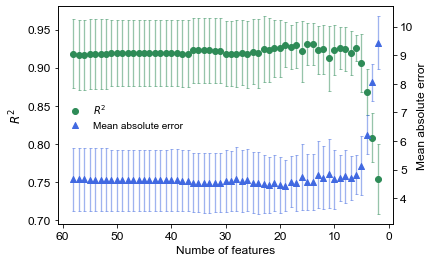

In [26]:
import matplotlib.pyplot as plt
import numpy as np
#import matplotlib
#cmap = matplotlib.colors.ListedColormap(matplotlib.cm.get_cmap("bwr").colors[:5])


font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)

fig = plt.figure()

ax = fig.add_subplot(111)
plt.scatter(x, y1, color='seagreen', alpha=1, label = '$R^2$')
plt.errorbar(x, y1, yerr=e1, color='seagreen', linestyle="None",alpha=0.5, lw=1.3, capsize=1.5)

ax.invert_xaxis()
# ax.fill_between(x, y1-e1, y1+e1,
#                        alpha=0.2, edgecolor='#CC4F1B', facecolor='#FF9848')
ax.set_xlabel('Numbe of features')
ax.set_ylabel('$R^2$')

ax2 = ax.twinx()
ax2.scatter(x, y2, color='royalblue',label = 'Mean absolute error', marker='^')
ax2.errorbar(x, y2, yerr=e2, color='royalblue', linestyle="None", alpha=0.5, lw=1.3, capsize=1.5)

ax2.set_ylabel('Mean absolute error')
# ax.xlabel('Numbe of features')
# ax.ylabel('$R^2$')
fig.legend(loc="center left", bbox_to_anchor=(0.12, 0.5), frameon = False, fontsize = 10)
#plt.setp(plot.get_legend().get_texts(), fontsize='10')
#plt.show()
plt.savefig('Feature_number_stats_oper_all.pdf')

#### use the reduced important features to predict methane yield

In [93]:
Oper_trans[Feature_list[51]]

,OLR,VSS,Hydrolysis efficiency,VFA.eff,V GAC/V total,tCOD.eff
0,1.9,14.50,NaN,NaN,0.0,0.768
1,1.4,17.70,NaN,NaN,0.0,1.280
2,1.0,6.00,NaN,NaN,0.0,0.544
3,1.0,5.05,NaN,NaN,0.0,0.352
4,1.0,13.30,NaN,NaN,0.0,0.672
...,...,...,...,...,...,...
356,4.8,18.35,88.144220,743.0,0.0,9.440
357,1.7,19.10,74.047977,990.4,0.0,9.250
358,1.7,19.10,74.047977,990.4,0.0,9.250
359,1.7,19.10,74.047977,1049.3,0.0,9.580


In [16]:
# Oper_trans_reduc=Oper_trans[Feature_list[51]]
Oper_trans_reduc=Oper_trans[['OLR', 'VSS', 'Hydrolysis efficiency', 'VFA.eff', 'V GAC/V total','tCOD.eff']]

In [17]:
S_split = SKf_gen.split(Oper_trans_reduc, S_group)

# outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# outer_cv_1 = KFold(n_splits=5, shuffle=True, random_state=10)
scoring = ['neg_mean_absolute_error', 'r2']
cv_results = cross_validate(
    search_cv, Oper_trans_reduc, Target, cv=S_split, n_jobs=2, return_estimator=True, scoring=scoring)    #here the cv is the outer cross validation

In [18]:
# this is used to verify the searchcv.best_estimator_ retrieve the correct tuned parameters
cv_results_test = pd.DataFrame(cv_results)
cv_test_error = -cv_results_test["test_neg_mean_absolute_error"]
cv_test_error_df = pd.DataFrame(cv_test_error)

for cv_fold, estimator_in_fold in enumerate(cv_results_test["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'learning_rate': 0.1, 'max_depth': 17, 'min_child_samples': 18, 'num_leaves': 129}
Best hyperparameters for fold #2:
{'learning_rate': 0.3, 'max_depth': 9, 'min_child_samples': 18, 'num_leaves': 85}
Best hyperparameters for fold #3:
{'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 3, 'num_leaves': 399}
Best hyperparameters for fold #4:
{'learning_rate': 0.3, 'max_depth': 3, 'min_child_samples': 3, 'num_leaves': 399}
Best hyperparameters for fold #5:
{'learning_rate': 0.1, 'max_depth': 13, 'min_child_samples': 5, 'num_leaves': 460}


In [19]:
cv_results_test

,fit_time,score_time,estimator,test_neg_mean_absolute_error,test_r2
0,8.362714,0.000801,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",-5.467725,0.918049
1,8.355295,0.000720,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",-5.273886,0.925128
2,8.541374,0.000535,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",-4.625138,0.923032
3,8.125213,0.000566,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",-5.053628,0.910502
4,4.758788,0.000684,"RandomizedSearchCV(cv=ShuffleSplit(n_splits=5,...",-3.732385,0.955123


In [20]:
Train = [pd.DataFrame() for df in range(5)]
Test = [pd.DataFrame() for df in range(5)]
for idx, split_index in enumerate(SKf_gen.split(Oper_trans_reduc, S_group)):
        # print("Split_count:", idx, "TRAIN:", split_index[0], "TEST:", split_index[1])
        Train[idx] = Oper_trans.loc[split_index[0]]
        Test[idx]= Oper_trans.loc[split_index[1]]

i = cv_results_test['test_r2'].idxmax()
        
Target_tune_para = Target.loc[Train[i].index]

search_cv.fit(X = Train[i], y = Target_tune_para)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=0.8),
                   estimator=LGBMRegressor(random_state=42, use_missing=True),
                   n_iter=20, n_jobs=2,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.1,
                                                          0.3, 0.5],
                                        'max_depth': <__main__.loguniform_int object at 0x14e1b04f0>,
                                        'min_child_samples': <__main__.loguniform_int object at 0x14e1ac790>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x14e13a4f0>},
                   random_state=0, scoring='neg_mean_absolute_error')

In [21]:
search_cv.best_estimator_

LGBMRegressor(max_depth=13, min_child_samples=5, num_leaves=460,
              random_state=42, use_missing=True)

In [22]:
from sklearn.model_selection import cross_val_predict

S_split = SKf_gen.split(Oper_trans_reduc, S_group)
Target_pred = cross_val_predict(search_cv.best_estimator_, Oper_trans_reduc, Target, cv=S_split)
# Target_pred

from sklearn.metrics import mean_absolute_error
#target_predicted = Tuned_model.predict(data_test)
print(f"Mean absolute error: "
      f"{mean_absolute_error(Target, Target_pred):.3f}")
MAE=mean_absolute_error(Target, Target_pred)

from sklearn.metrics import r2_score
print(f"r^2_score: "
      f"{r2_score(Target, Target_pred):.3f}")
R2_score=r2_score(Target, Target_pred)

from sklearn.metrics import mean_squared_error
print(f"Root mean squared error on the training set: "
      f"{mean_squared_error(Target, Target_pred, squared=False):.3f}")
RMSE=mean_squared_error(Target, Target_pred, squared=False)

Mean absolute error: 4.820
r^2_score: 0.918
Root mean squared error on the training set: 7.287


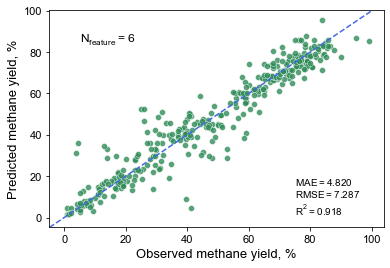

In [103]:
Target_ob_pre = pd.DataFrame({'Observed':Target, 'Predicted':Target_pred})

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

ax = sns.scatterplot(data=Target_ob_pre,
                x="Observed", y="Predicted",
                color="seagreen", alpha=0.8)

tex = f'$MAE = {MAE:.3f}$\n$RMSE = {RMSE:.3f}$\n$R^2 = {R2_score:.3f}$'.format(MAE,R2_score,RMSE)

ax.text(75, 20, tex, fontsize=10,
        verticalalignment='top')
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.axline((0, 0), slope=1, linestyle = '--', color = 'royalblue', alpha=1)
ax.set_xlabel("Observed methane yield, %",fontsize=13)
ax.set_ylabel("Predicted methane yield, %",fontsize=13)
ax.text(5,85,'$N _{feature}=6$',fontsize=12,font='Arial')
#ax.axis('square')
plt.savefig('Predict_observed_oper_all_reduction.pdf')

In [23]:
best_model = search_cv.best_estimator_.fit(Oper_trans_reduc, Target)
explainer = shap.Explainer(best_model)
shap_values = explainer(Oper_trans_reduc)

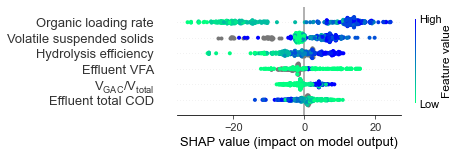

In [122]:
shap.summary_plot(shap_values, Oper_trans_reduc, max_display=30, plot_size=[5,2],show=False, cmap="winter_r",color_bar=True)
plt.gcf().axes[-1].set_aspect(70)
plt.gcf().axes[-1].set_box_aspect(90)
plt.yticks(ticks=[0, 1, 2, 3, 4, 5],
           labels=['Effluent total COD','$V_{GAC}/V_{total}$','Effluent VFA',
                  'Hydrolysis efficiency','Volatile suspended solids',
                  'Organic loading rate'])
plt.savefig('sharpley_beeswarm_oper_all_reduction.pdf',bbox_inches='tight')

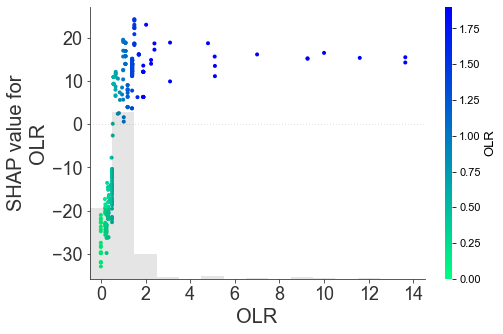

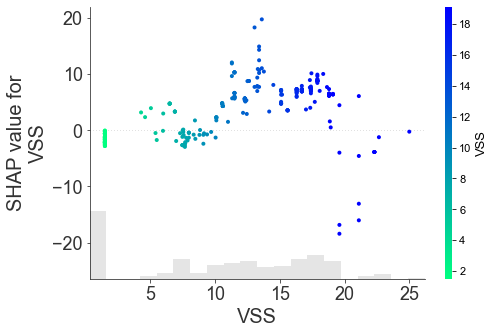

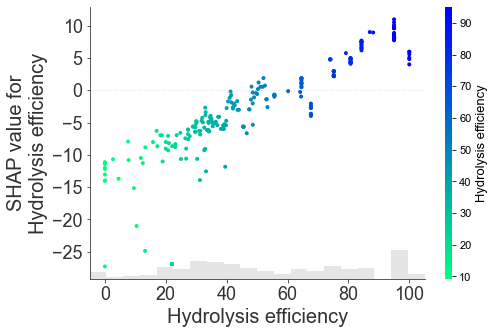

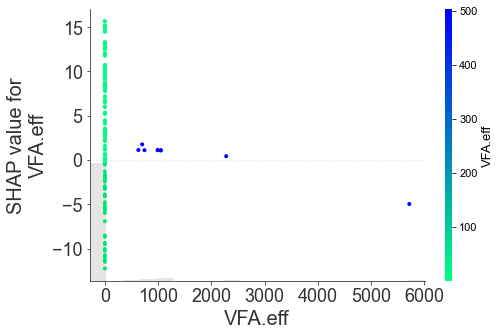

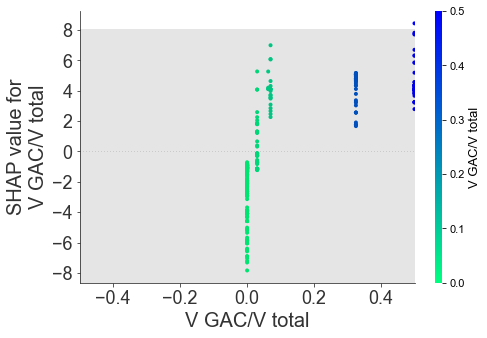

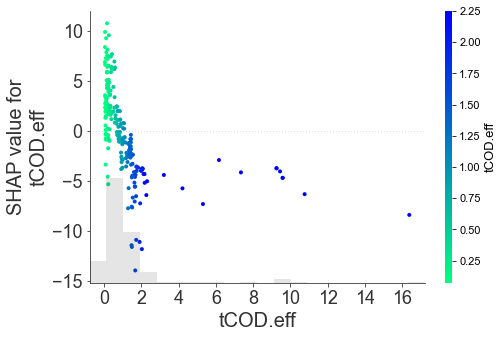

In [60]:
# import matplotlib as mpl
# from matplotlib.backends.backend_pdf import PdfPages
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 20}
plt.rc('font', **font)

# mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.it'] = 'Arial:italic'

pdf = PdfPages("./20241016_Effects_for_each_operational_reduction.pdf")
for i in Oper_trans_reduc:
    # shap.plots.scatter(shap_values_all[:,"Methanothrix"], color=shap_values_all[:,i], 
    #                    cmap="winter_r",show=False)
    shap.plots.scatter(shap_values[:,i], color=shap_values[:,i], 
                   cmap="winter_r",show=False)
    plt.gcf().axes[-2].set_aspect('auto')
    # plt.gcf().axes[-2].set_aspect(50)
    plt.gcf().axes[-2].set_box_aspect(40)
    plt.xlabel(i, fontsize=20)
    plt.ylabel("SHAP value for\n"+i, fontsize=20)
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    # plt.legend(title_fontsize = 16)
    pdf.savefig(bbox_inches = 'tight')
pdf.close()

In [46]:
for i in Oper_trans_reduc:
    print("sharp value for\n"+i)

sharp value for
OLR
sharp value for
VSS
sharp value for
Hydrolysis efficiency
sharp value for
VFA.eff
sharp value for
V GAC/V total
sharp value for
tCOD.eff


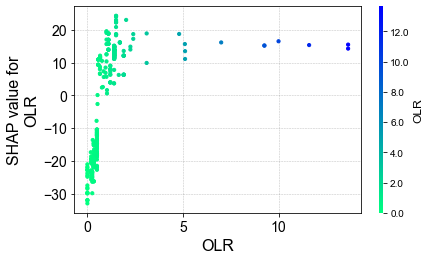

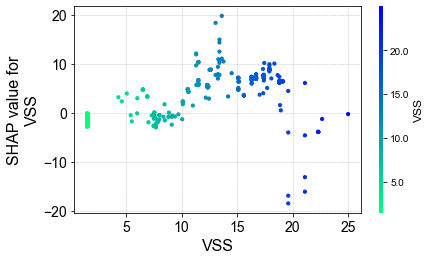

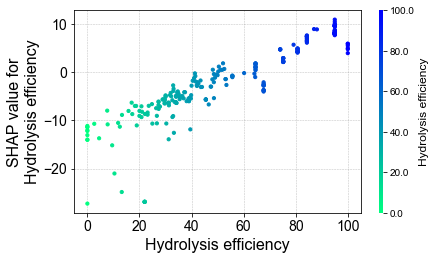

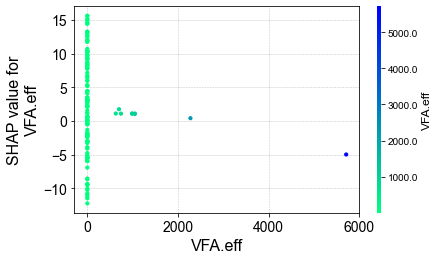

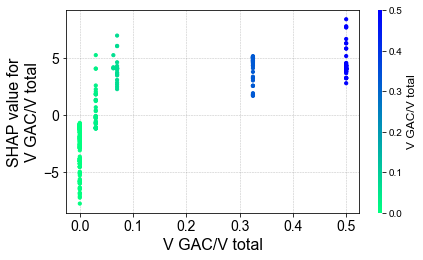

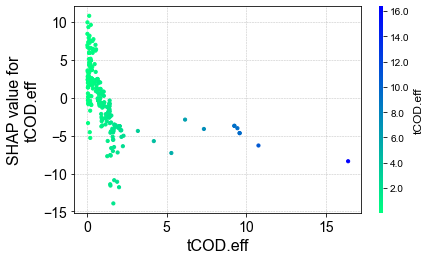

In [80]:
pdf = PdfPages("./20241016_Effects_for_each_operational_reduction_1.pdf")
for i in Oper_trans_reduc:
    
    fig, ax = plt.subplots(tight_layout=True, figsize=(6.5, 4))

    # or you need more flexible customization
    scatter = ax.scatter(
        shap_values[:,i].data,
        shap_values[:,i].values,
        c=shap_values[:,i].data,
        # marker="^",
        cmap=plt.get_cmap("winter_r"),
        rasterized=True,
        zorder=5,
        s=10
    )

    cbar = plt.colorbar(scatter, aspect=50, format="%2.1f")
    cbar.set_label(i, fontsize=12)
    cbar.outline.set_visible(False)
    cbar.ax.tick_params(labelsize=10)

    # ax.set_title("Customization", fontsize=18)
    ax.set_xlabel(i, fontsize=16)
    ax.set_ylabel("SHAP value for\n"+i, fontsize=16)

    ax.tick_params(labelsize=14)

    ax.grid(linestyle="--", color="gray", linewidth=0.5, zorder=0, alpha=0.5)
    pdf.savefig(bbox_inches = 'tight', dpi = 200)
pdf.close()

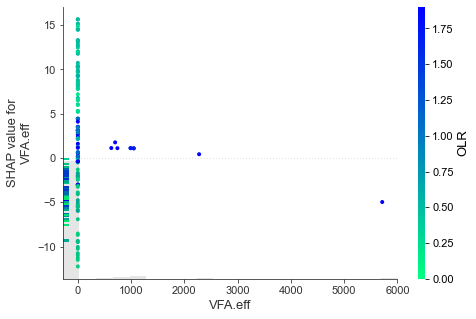

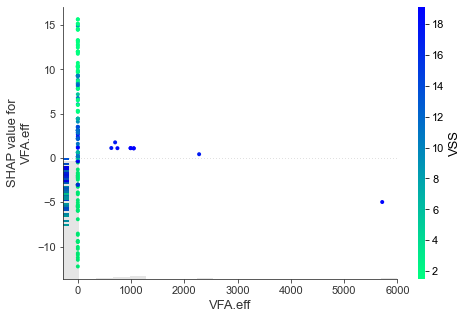

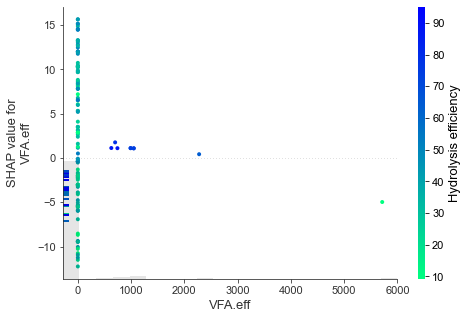

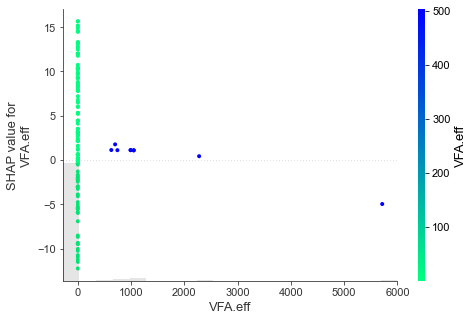

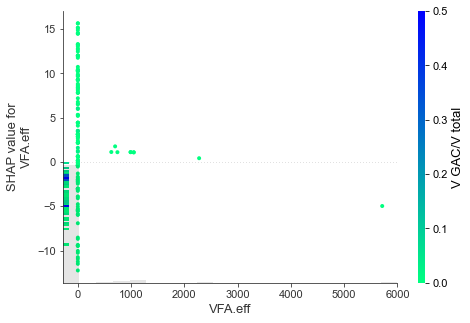

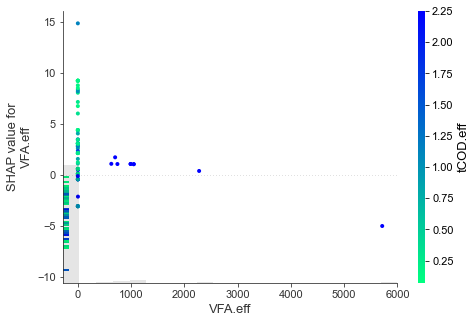

In [23]:
import matplotlib.pyplot as plt
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.it'] = 'Arial:italic'

# pdf = PdfPages("./Effects_for_each_operational_reduction.pdf")
for i in Oper_trans_reduc:
    # shap.plots.scatter(shap_values_all[:,"Methanothrix"], color=shap_values_all[:,i], 
    #                    cmap="winter_r",show=False)
    shap.plots.scatter(shap_values[:,"VFA.eff"], color=shap_values[:,i], 
                   cmap="winter_r",show=False)
    plt.gcf().axes[-2].set_aspect('auto')
    plt.gcf().axes[-2].set_box_aspect(40)
    # pdf.savefig()
# pdf.close()

In [ ]:
plt.yticks(ticks=[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
          labels=['$V_{GAC}/V_{total}$','$\it{Methanosphaera}$','Effluent total COD',
                  '$\it{Methanomassiliicoccus}$','$\it{Methanothrix}$','$\it{Litorilinea}$',
                  'Volatile suspended solids','Effluent VFA','Hydrolysis efficiency','Organic loading rate'])


In [122]:
Train = [pd.DataFrame() for df in range(5)]
Test = [pd.DataFrame() for df in range(5)]
for idx, split_index in enumerate(SKf_gen.split(Oper_trans, S_group)):
        # print("Split_count:", idx, "TRAIN:", split_index[0], "TEST:", split_index[1])
        Train[idx] = Oper_trans.loc[split_index[0]]
        Test[idx]= Oper_trans.loc[split_index[1]]


In [117]:
Train[4]

,Reactor type_Anaerobic sequencing batch reactors,Reactor type_UASB,Feeding strategy_Continuous,Feeding strategy_Continuous with eff recirculation,Feeding strategy_Semi-continuous,Substrate_50% Glucose + 50% BSA,Substrate_60% Glucose + 40% BSA,Substrate_75% Glucose + 25% BSA,Substrate_Acetate and glucose,Substrate_BSA,...,VFA.eff,FA,SRT,GAC amount,Specific surface area,V GAC/V total,Hydrolysis efficiency,Acidogenesis efficiency,SMA-acetate,SMA-hydrogen
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.1268,0.220
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.1540,0.133
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.2010,0.142
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.4960,3.540
5,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,0,0.0,0.0,NaN,NaN,0.0000,0.045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,743.0,35.933080,18.54,0,0.0,0.0,88.144220,NaN,NaN,NaN
357,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,990.4,258.748323,38.65,0,0.0,0.0,74.047977,NaN,NaN,NaN
358,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,990.4,258.748323,38.65,0,0.0,0.0,74.047977,NaN,NaN,NaN
359,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1049.3,35.933080,36.32,0,0.0,0.0,74.047977,NaN,NaN,NaN


In [124]:
Target_tune_para = Target.loc[Train[4].index]
Target_tune_para

0      56.0
1      33.0
2      70.0
3      74.0
5      25.0
       ... 
356    81.6
357    71.7
358    71.7
359    71.2
360    71.2
Name: Methanogenesis efficiency, Length: 289, dtype: float64

In [121]:
i = cv_test_error.idxmin()
i

4

In [141]:
search_cv.fit(X = Train[4], y = Target_tune_para)

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=0.8),
                   estimator=LGBMRegressor(random_state=42, use_missing=True),
                   n_iter=20, n_jobs=2,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.1,
                                                          0.3, 0.5],
                                        'max_depth': <__main__.loguniform_int object at 0x13ff60fa0>,
                                        'min_child_samples': <__main__.loguniform_int object at 0x13ff02d90>,
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x13ff0ea60>},
                   random_state=0, scoring='neg_mean_absolute_error')

In [127]:
    best_model = search_cv.best_estimator_.fit(Oper_trans, Target)
    explainer = shap.Explainer(best_model)
    shap_values = explainer(Oper_trans)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


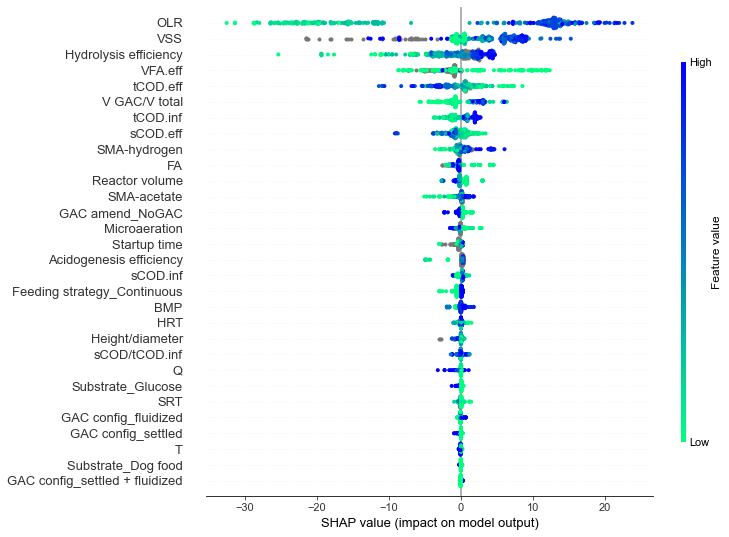

In [142]:
S_split = SKf_gen.split(Oper_group_temp2, S_group)
Target_pred = cross_val_predict(Regressor_tuned, Oper_trans, Target, cv=S_split)

from sklearn.metrics import mean_absolute_error
#target_predicted = Tuned_model.predict(data_test)
print(f"Mean absolute error: "
      f"{mean_absolute_error(Target, Target_pred):.3f}")
MAE=mean_absolute_error(Target, Target_pred)

from sklearn.metrics import r2_score
print(f"r^2_score: "
      f"{r2_score(Target, Target_pred):.3f}")
R2_score=r2_score(Target, Target_pred)

from sklearn.metrics import mean_squared_error
print(f"Root mean squared error on the training set: "
      f"{mean_squared_error(Target, Target_pred, squared=False):.3f}")
RMSE=mean_squared_error(Target, Target_pred, squared=False)

Mean absolute error: 4.605
r^2_score: 0.919
Root mean squared error on the training set: 7.263


In [138]:
search_cv.best_estimator_

LGBMRegressor(max_depth=13, min_child_samples=5, num_leaves=460,
              random_state=42, use_missing=True)